In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset, RandomSampler
import torch
from torch import nn, optim
import numpy as np
from utils import timing_decorator, get_images_dir_path
import pandas

In [2]:
result_folder = 'autoencoder_results'
images_dir = get_images_dir_path()
num_input = 96 * 54
batch_size = 64
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
num_epochs = 50

In [3]:
images_dir

'/Users/rrminyukov/PycharmProjects/ml-basics/dance-moves/images'

In [4]:
os.makedirs(result_folder, exist_ok=True)
results_file = os.path.join(result_folder, 'training_results.csv')

### Класс для датасета изображений

In [5]:
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = read_image(img_name)
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]

In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

In [7]:
dataset = ImageFolderDataset(root_dir='images', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size)

### Проверка датасета

Feature batch shape: torch.Size([64, 1, 54, 96])
Feature [0] batch shape: torch.Size([1, 54, 96])


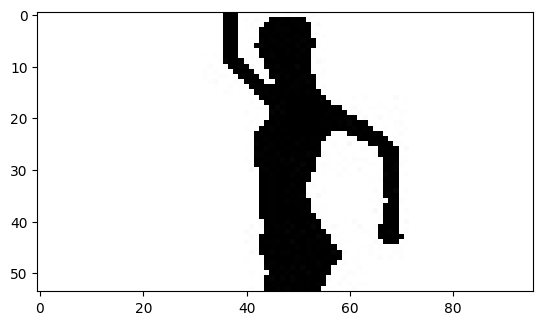

In [8]:
features, _ = next(iter(dataloader))
print(f"Feature batch shape: {features.size()}")
print(f"Feature [0] batch shape: {features[0].shape}")

img = features[0].squeeze()
plt.imshow(img, cmap="gray")
plt.show()

### Класс Autoencoder

In [9]:
from autoencoder import Autoencoder

### Обучение Autoencoder

In [10]:
@timing_decorator
def train(num_epochs, dataloader, num_input):
    autoencoder_model = Autoencoder()
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(autoencoder_model.parameters())
    autoencoder_model.to(device)

    with open(results_file, 'w') as f:
        f.write('Epoch,Loss\n')
    
    print(f'Обучение начато на {num_epochs} эпох')
    min_train_loss = 10^5
    for epoch in range(num_epochs):
        train_loss = 0
        for data in dataloader:
            inputs, _ = data
            inputs = inputs.to(device)
    
            optimizer.zero_grad()
            
            encoded, decoded = autoencoder_model(inputs)

            loss = loss_function(decoded, inputs)
    
            loss.backward()
            
            train_loss += loss.item()
            optimizer.step()

        if epoch % 5 == 0:
            print(f'-> Эпоха: {epoch} Средний loss: {train_loss:.4f}')
            with open(results_file, 'a') as f:
                f.write(f'{epoch+1},{train_loss:.4f}\n')

        if min_train_loss > train_loss:
            min_train_loss = train_loss

    
    torch.save(autoencoder_model.state_dict(), os.path.join(result_folder, f'autoencoder.pth'))
    print('Окончание обучения')

In [11]:
train(num_epochs, dataloader, num_input)

Обучение начато на 50 эпох
-> Эпоха: 0 Средний loss: 25.1960
-> Эпоха: 5 Средний loss: 4.4223
-> Эпоха: 10 Средний loss: 3.2765
-> Эпоха: 15 Средний loss: 2.7857
-> Эпоха: 20 Средний loss: 2.5278
-> Эпоха: 25 Средний loss: 2.3342
-> Эпоха: 30 Средний loss: 2.1392
-> Эпоха: 35 Средний loss: 2.0715
-> Эпоха: 40 Средний loss: 1.9262
-> Эпоха: 45 Средний loss: 1.8567
Окончание обучения
Время выполнения train: 817.07 секунд


### Результаты Autoencoder

In [27]:
def load_autoencoder_model(model_path):
    model = Autoencoder()
        
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()

    return model


In [28]:
model_path = os.path.join(result_folder, 'autoencoder.pth')

model = load_autoencoder_model(model_path)
images_count = 5

In [29]:
def use_autoencoder_model_with_dataloader(model, dataloader, size=5):
    reconstructed_images = []
    model = model.to(device)
    
    inputs, _ = next(iter(dataloader))
    inputs = inputs.to(device)

    with torch.no_grad():
        _, reconstructed = model(inputs)
    
    for i in range(reconstructed.size(0)):
        original_image = inputs[i].cpu().squeeze(0)
        reconstructed_image = reconstructed[i].cpu().squeeze(0)
        reconstructed_images.append([original_image, reconstructed_image])

    return reconstructed_images[:size]

torch.Size([54, 96])
torch.Size([54, 96])


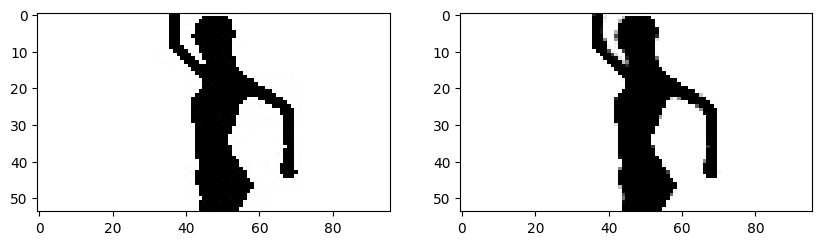

torch.Size([54, 96])
torch.Size([54, 96])


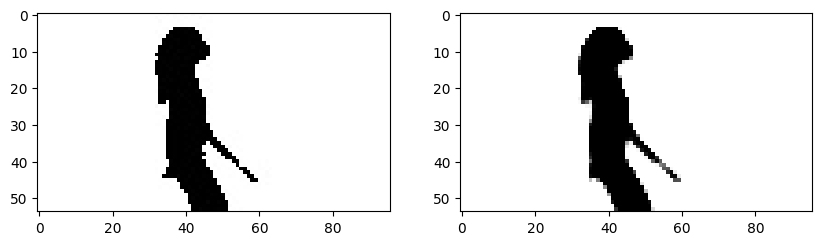

torch.Size([54, 96])
torch.Size([54, 96])


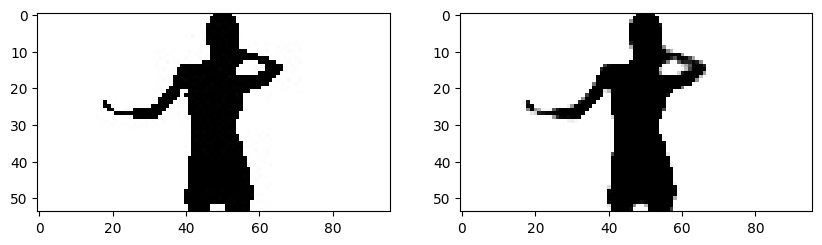

torch.Size([54, 96])
torch.Size([54, 96])


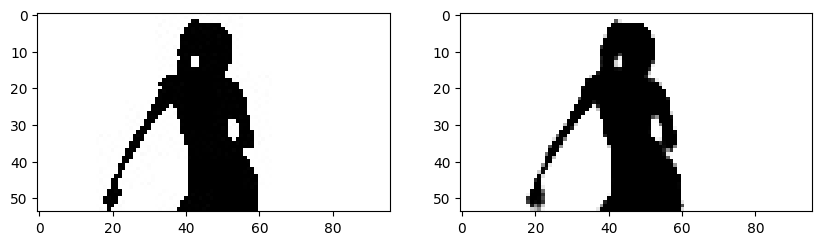

torch.Size([54, 96])
torch.Size([54, 96])


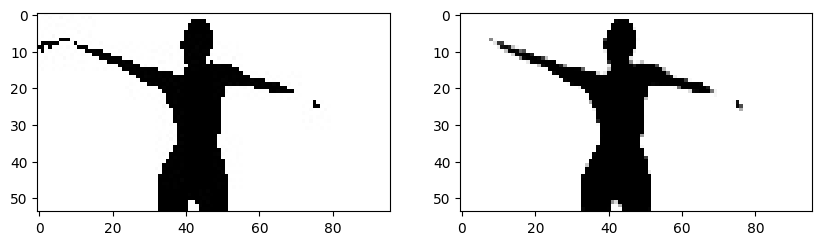

torch.Size([54, 96])
torch.Size([54, 96])


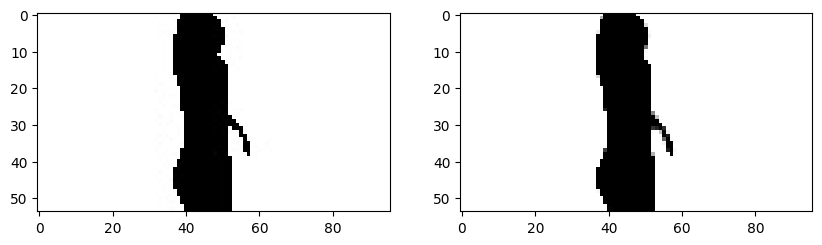

torch.Size([54, 96])
torch.Size([54, 96])


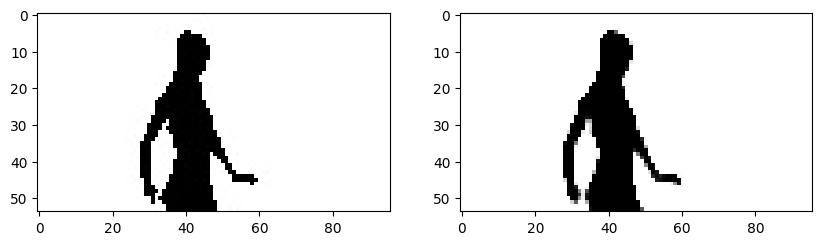

torch.Size([54, 96])
torch.Size([54, 96])


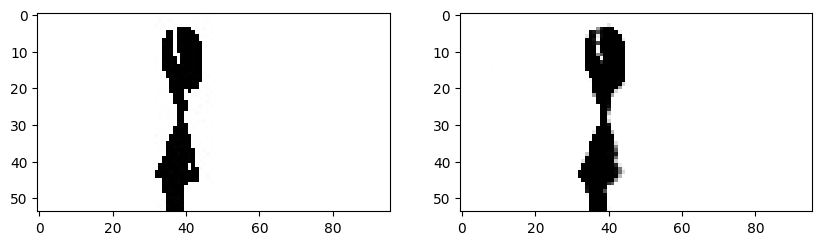

torch.Size([54, 96])
torch.Size([54, 96])


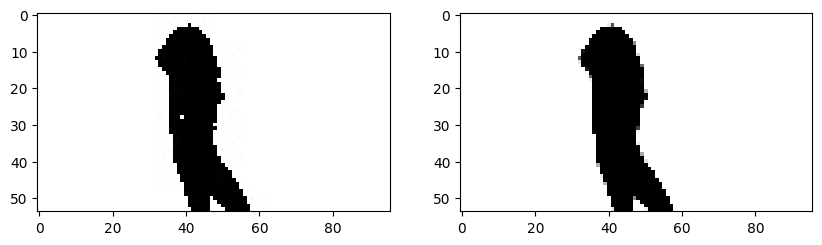

torch.Size([54, 96])
torch.Size([54, 96])


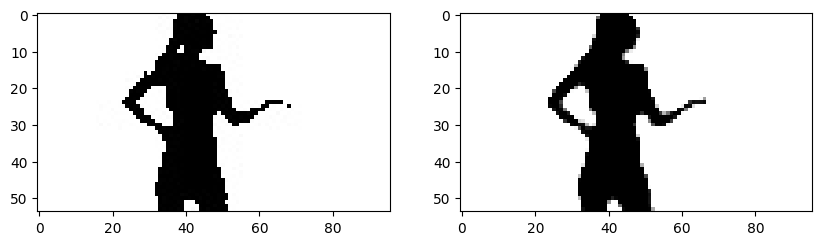

torch.Size([54, 96])
torch.Size([54, 96])


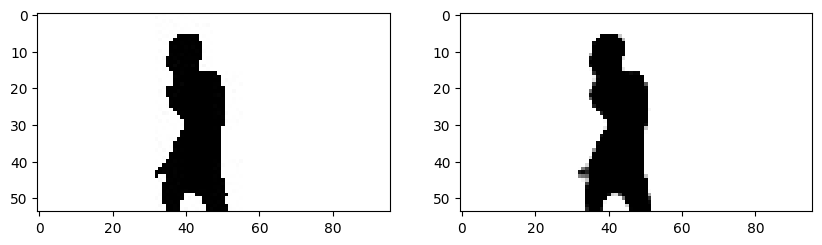

torch.Size([54, 96])
torch.Size([54, 96])


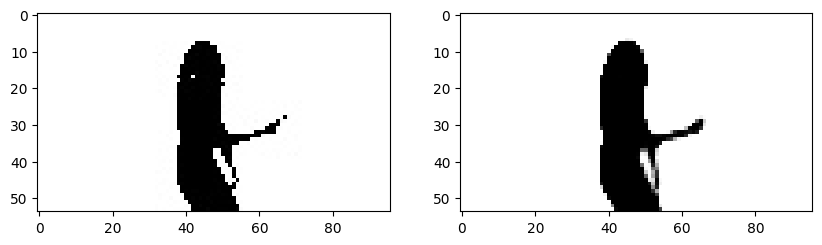

torch.Size([54, 96])
torch.Size([54, 96])


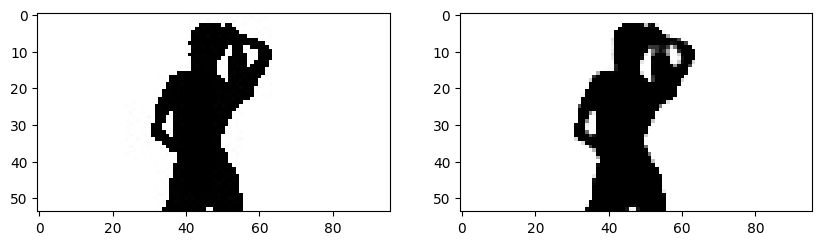

torch.Size([54, 96])
torch.Size([54, 96])


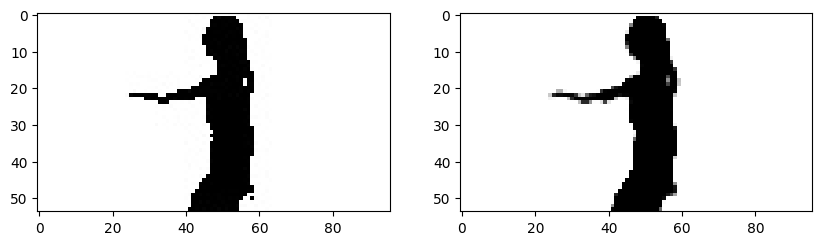

torch.Size([54, 96])
torch.Size([54, 96])


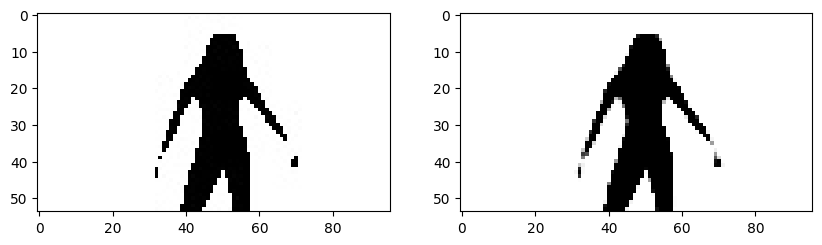

In [30]:
reconstructed_images = use_autoencoder_model_with_dataloader(model, dataloader, 15)
for original_image, reconstructed_image  in reconstructed_images:   
    print(original_image.shape)
    print(reconstructed_image.shape)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap="gray")
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image, cmap="gray")
    plt.show()

### График обучения

In [31]:
df = pandas.read_csv(results_file)

In [32]:
df.head()

,Epoch,Loss
0,1,23.7891
1,6,4.5140
2,11,3.3747
3,16,2.8572
4,21,2.6094


<Axes: xlabel='Epoch'>

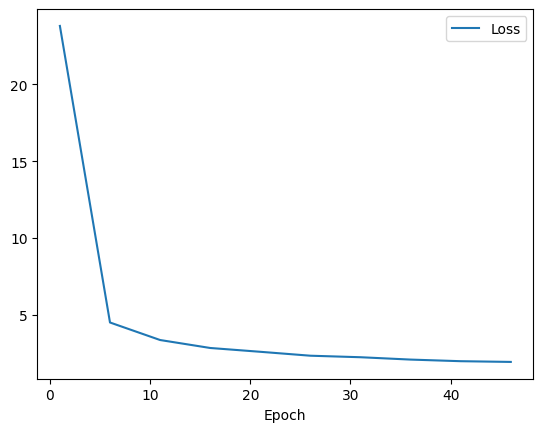

In [33]:
df.plot(x = 'Epoch', y = 'Loss')

### Создание векторов Autoencoder

In [34]:
vectors_model = load_autoencoder_model(model_path)

In [35]:
output_file_name = 'encoded_vectors.csv'
encoded_vectors = os.path.join(result_folder, output_file_name)

In [36]:
@timing_decorator
def create_vectors(model):
    model.to(device)
    
    print("Начало создания векторов")   
    with open(encoded_vectors, 'w') as f:
        f.write('file_name,encode_vector\n')
        idx = 0
        for inputs, filenames in dataloader:
            inputs = inputs.to(device)

            with torch.no_grad():
                encoded = model.encoder(inputs)

            for i in range(encoded.size(0)):
                encoded_vector = encoded[i].cpu().numpy().flatten()
                encoded_vector_str = ','.join(map(str, encoded_vector))
                f.write(f'{filenames[i]},"{encoded_vector_str}"\n')
    
                if idx % 5000 == 0:
                    print(f"Обработано веторов: {idx}")
                idx += 1
    print("Окончание создания векторов")   

In [37]:
create_vectors(vectors_model)

Начало создания векторов
Обработано веторов: 0
Обработано веторов: 5000
Обработано веторов: 10000
Обработано веторов: 15000
Обработано веторов: 20000
Обработано веторов: 25000
Обработано веторов: 30000
Обработано веторов: 35000
Обработано веторов: 40000
Обработано веторов: 45000
Окончание создания векторов
Время выполнения create_vectors: 17.80 секунд
